In [1]:
#smo算法，里面的公式很复杂，这里只是简化版本，详细版本请参见原版代码
#SMO基本思路：1.选取一对需要更新的alpha(i)和alpha(j) 2.固定其他的alpha,更新这两个值直到收敛
#关键：怎么选取两个alpha值？   +  怎么更新？
import numpy as np
#load data from file导入txt数据
def load_data(filename):
    dataset = []
    label = []
    file = open(filename)
    for line in file.readlines():
        lineArr = line.strip().split('\t')
        m = len(lineArr)
        dataset.append(lineArr[0:m-1])
        label.append(lineArr[-1])    
    return np.array(dataset,dtype=np.float64),\
           np.array(label,dtype=np.int).reshape(-1,1)


(100L, 2L) (100L, 1L)
[ 3.542485  1.977398] [-1]


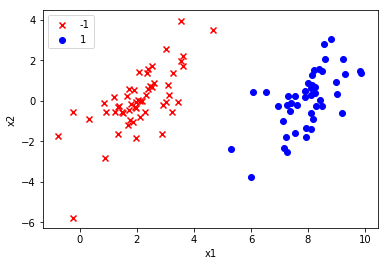

In [5]:
import matplotlib.pyplot as plt
#导入数据并且可视化一下
x,y = load_data("svm/testSet.txt")
print x.shape,y.shape
print x[0],y[0]

label1 = np.where(y.ravel() == -1)
plt.scatter(x[label1,0],x[label1,1],marker='x',color = 'r',label = '-1')
label2 = np.where(y.ravel() == 1)
plt.scatter(x[label2,0],x[label2,1],marker='o',color = 'b',label = '1')
    
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc = 'upper left')
plt.show()


In [6]:
def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(np.random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = np.mat(dataMatIn); labelMat = np.mat(classLabels).transpose()
    b = 0; m,n = np.shape(dataMatrix)
    alphas = np.mat(np.zeros((m,1)))
    iter = 0
    while (iter < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])#if checks if an example violates KKT conditions
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                j = selectJrand(i,m)
                fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H:
                    #print "L==H"
                    continue
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0: 
                    #print "eta>=0"
                    continue
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    #print "j not moving enough"
                    continue
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])#update i by the same amount as j
                                                                        #the update is in the oppostie direction
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                #print "iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)
        if (alphaPairsChanged == 0): iter += 1
        else: iter = 0
        #print "iteration number: %d" % iter
    return b,alphas

In [7]:
import time

t0 = time.time()
b,alphas = smoSimple(x,y.ravel(),0.6,0.001,40)
t1 = time.time()
print "Total time running %f seconds" %(t1-t0)
print alphas.shape
print alphas[alphas>0]

Total time running 6.568000 seconds
(100L, 1L)
[[ 0.05805216  0.28772265  0.07965433  0.26612048]]


In [10]:
def calcWs(alphas,dataArr,classLabels):
    X = np.mat(dataArr)
    labelMat = np.mat(classLabels).transpose()
    m,n = np.shape(X)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

w = calcWs(alphas,x,y.ravel())
print w.shape
print w


(2L, 1L)
[[ 0.77418358]
 [-0.25633008]]


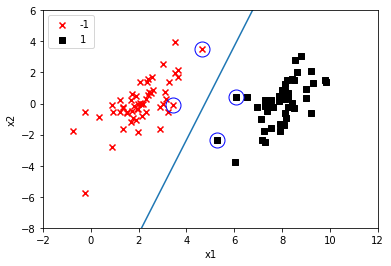

In [13]:
label1 = np.where(y.ravel() == -1)
plt.scatter(x[label1,0],x[label1,1],marker='x',color = 'red',label = '-1')
label2 = np.where(y.ravel() == 1)
plt.scatter(x[label2,0],x[label2,1],marker='s',color = 'black',label = '1')
#画出支持向量
supportIndex = np.nonzero(alphas>0)[0]
plt.plot(x[supportIndex,0],x[supportIndex,1],'bo',markersize=15,fillstyle='none')

#使用已知的参数画出超平面
b0 = b[0,0]; w0=w[0,0]; w1=w[1,0]
x0 = np.arange(-2.0, 12.0, 0.1)
y0 = (-w0*x0 - b0)/w1
plt.plot(x0,y0)
plt.axis([-2,12,-8,6])

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc = 'upper left')
plt.show()
